# **Value at Risk (VaR) calculation (Tesla,Amazon and Nvidia)**

This project calculates Value at Risk (VaR) for stock portfolios using Historical Simulation and Variance-Covariance methods, as well as Conditional VaR (CVaR) to assess the potential losses beyond the VaR threshold. Additionally, the project includes Rolling VaR, which tracks risk dynamically over time. The analysis is performed on Tesla, Amazon, and Nvidia stocks, with visual comparisons of the different VaR methods.

**Step 1 — Import Stock Price Data**

We get recent historical prices and pull daily adjusted closing prices from 2022 to 2024 for Tesla, Amazon, and Nvidia

In [4]:
# Install yfinance if needed
!pip install yfinance --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define tickers and download data
tickers = ['TSLA', 'AMZN', 'NVDA']
data = yf.download(tickers, start='2022-01-01', end='2024-12-31')['Close']

# Show the head
data.head()


[*********************100%***********************]  3 of 3 completed


Ticker,AMZN,NVDA,TSLA
Date,,,
2022-01-03,170.404495,30.068224,399.926666
2022-01-04,167.522003,29.238680,383.196655
2022-01-05,164.356995,27.555634,362.706665
2022-01-06,163.253998,28.128626,354.899994
2022-01-07,162.554001,27.199259,342.320007


**Step 2: Calculate Daily Returns.**

We use log returns (log(P_t / P_t-1)) because they are more stable and additive over time (good for VaR modeling)

In [5]:
# Calculate daily log returns
returns = np.log(data / data.shift(1)).dropna()

# Show the head
returns.head()


Ticker,AMZN,NVDA,TSLA
Date,,,
2022-01-04,-0.017060,-0.027976,-0.042733
2022-01-05,-0.019074,-0.059285,-0.054954
2022-01-06,-0.006734,0.020581,-0.021758
2022-01-07,-0.004297,-0.033598,-0.036090
2022-01-10,-0.006592,0.005599,0.029891


**Step 3: Historical Simulation VaR**

In Historical Simulation, we simply:

*   Take past returns

*   Find the 5th percentile (for 95% confidence level)

This gives you, for each stock:

*   How much % loss you should not exceed with 95% probability (based on historical returns).

In [6]:
# Set confidence level
confidence_level = 0.95

# Calculate Historical VaR (5th percentile of returns)
historical_var = returns.quantile(1 - confidence_level)

print("Historical Simulation VaR (95% confidence):")
print(historical_var)


Historical Simulation VaR (95% confidence):
Ticker
AMZN   -0.037070
NVDA   -0.054123
TSLA   -0.065298
Name: 0.050000000000000044, dtype: float64


**Step 4: Variance-Covariance VaR**

This method assumes returns are Normally distributed.

We use the formula:

VaR
=
𝜇
+
𝑧
×
𝜎


Where:


*   μ = mean return


*   σ = standard deviation of returns


*   z = Z-score for 95% confidence (~ -1.645)

This will print the parametric VaR assuming Normal distribution.

In [7]:
from scipy.stats import norm

# Calculate mean and standard deviation of returns
mean_returns = returns.mean()
std_returns = returns.std()

# Get Z-score for 95% confidence level
z_score = norm.ppf(1 - confidence_level)

# Variance-Covariance VaR
var_cov_var = mean_returns + z_score * std_returns

print("Variance-Covariance VaR (95% confidence):")
print(var_cov_var)


Variance-Covariance VaR (95% confidence):
Ticker
AMZN   -0.039408
NVDA   -0.054626
TSLA   -0.063329
dtype: float64


**Step 5: Calculate Conditional VaR (CVaR)**

Quick Concept:
*   VaR tells you: “You have a 5% chance of losing more than X.”

*   CVaR tells you: “If you lose more than X, your average loss will be Y.”

👉 most risk managers in finance prefer CVaR — coz it’s a deeper measure of tail risk!

In [8]:
# Calculate CVaR (also called Expected Shortfall)
cvar = returns[returns <= historical_var].mean()

print("Conditional VaR (CVaR) at 95% confidence:")
print(cvar)


Conditional VaR (CVaR) at 95% confidence:
Ticker
AMZN   -0.055888
NVDA   -0.071026
TSLA   -0.087924
dtype: float64


**Step 6: Plot and Compare VaR and CVaR**

This creates a side-by-side bar chart for Tesla, Amazon, and Nvidia showing:

*   Historical VaR

*   Variance-Covariance VaR

*   Conditional VaR (CVaR)

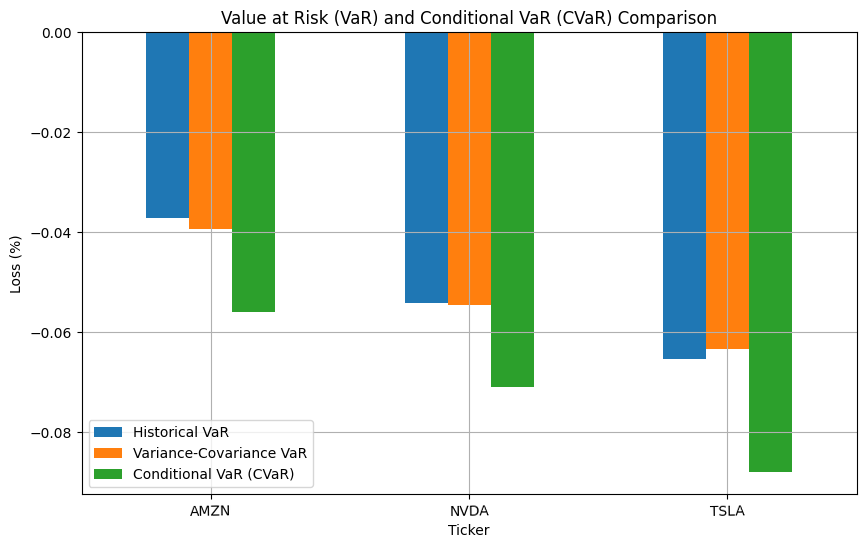

In [12]:
# Prepare a dataframe to compare
var_comparison = pd.DataFrame({
    'Historical VaR': historical_var,
    'Variance-Covariance VaR': var_cov_var,
    'Conditional VaR (CVaR)': cvar
})

# Plot
var_comparison.plot(kind='bar', figsize=(10,6))
plt.title('Value at Risk (VaR) and Conditional VaR (CVaR) Comparison')
plt.ylabel('Loss (%)')
plt.grid(True)
plt.xticks(rotation=1)
plt.show()


**Added Task: Rolling VaR**

Instead of one fixed VaR number, track how VaR changes over time!

Risk managers always monitor dynamic risk 📈 — especially important during market crashes.

This shows:

*   How Tesla, Amazon, and Nvidia risk levels changed over time.

*   Spikes during high volatility events.

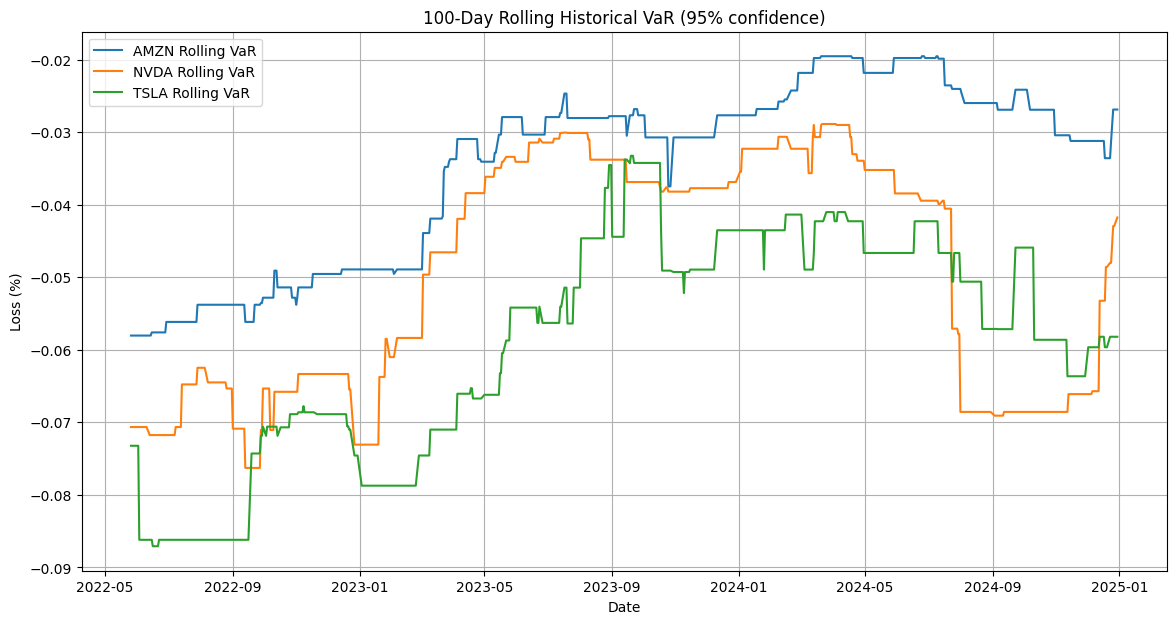

In [13]:
# Rolling window size (e.g., 100 days)
window_size = 100

# Rolling Historical VaR
rolling_var = returns.rolling(window=window_size).quantile(1 - confidence_level)

# Plot Rolling VaR
plt.figure(figsize=(14,7))

for stock in rolling_var.columns:
    plt.plot(rolling_var.index, rolling_var[stock], label=f'{stock} Rolling VaR')

plt.title(f'{window_size}-Day Rolling Historical VaR (95% confidence)')
plt.ylabel('Loss (%)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()
